# **** WASTE MANAGEMENT SYSTEM ****
##Waste Classifier uinsg PyTorch and ResNet50

Classez les dechets selon la matière: 
'trash' (poubelle), 

*  'cardboard' (carton),
*  'glass' (verre),
*  'plastic' (plastique), 
*  'paper' (papier),
*  'metal' (métal) 

In [167]:
# od.download('https://www.kaggle.com/asdasdasasdas/garbage-classification')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries utilisées 📚📚


In [168]:
import os
import torch
import torchvision 
from torchvision import datasets
from torch.utils.data import random_split
import torchvision.models as tvmodels
import torch.nn as tn
import torch.nn.functional as Ftn
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as totransformsimport matplotlib.pyplot as plt

## Hyper-parameters

In [169]:
b_size = 32 # Batch Size
num_epochs = 2
lr = 5.5e-5

# **Transformations:**

Avant d'utiliser les images de notre modèle, il faut appliquer quelques transformations, notamment convertir les images en Tensors.

*   *NB : A tensor is a number, vector, matrix, or any n-dimensional array. *

In [170]:
transformations = totransforms.Compose([totransforms.Resize((256, 256)), 
                                        totransforms.ToTensor()])

In [171]:
data_directory  = datasets.ImageFolder('/content/drive/MyDrive/archive/Garbage classification/Garbage classification', transform=transformations)

###L'étape suivante :
Nous allons diviser les données en données de :

*   training:
*   validation and test datasets:

In [172]:
data_train, data_val, data_test = random_split(data_directory, [1593, 176, 758])

###Création des Data Loaders :
Ces Data Loaders chargent les données dans notre modèle par lots.

In [173]:
dataload_train = DataLoader(data_train, b_size, shuffle = True, num_workers = 4, pin_memory = True)
dataload_val = DataLoader(data_val, b_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **Définir le modèle Base:**

On commence par créer un modèle base:

In [174]:
def accur(resultats, etiquettes):
    _, predic = torch.max(resultats, dim=1)
    return torch.tensor(torch.sum(predic == etiquettes).item() / len(predic))

class ClassificationImageBase(tn.Module):
    
    def phase_training(self, batch):
        images, etiquettes = batch 
        pred = self(images)                  # Genère les prédictions
        perte = Ftn.cross_entropy(pred, etiquettes) # Calcule la perte
        return perte
    
    def phase_validation(self, batch):
        images, etiquettes = batch 
        pred = self(images)                    # Genère les prédictions
        perte = Ftn.cross_entropy(pred, etiquettes)   # Calcule la perte
        acc = accur(pred, etiquettes)           # Calcule l'accuracy
        return {'perte_val': perte.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['perte_val'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'perte_val': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, data_directory):
        print("Epoch {}: perte_train: {:.4f}, perte_val: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, data_directory['perte_train'], data_directory['perte_val'], data_directory['val_acc']))

# ResNet50 pour la classification des images:
Création d'un RESNET CNN

In [175]:
class ResNet(ClassificationImageBase):
    def __init__(self):
        super().__init__()
        
        # utiliser un modèle pré-entrainé 
        self.network = tvmodels.resnet50(pretrained=True)
    
        # Remplacer la dernière couche
        features_numero = self.network.fc.in_features
        self.network.fc = tn.Linear(features_numero, len(data_directory.classes))
    
    def forward(self, xvar):
        return torch.sigmoid(self.network(xvar))

mod = ResNet()



# Porting to GPU: *(Graphics processing unit)*

Using GPU for computation

In [176]:
def get_default_device():
    
    """device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Déplacer Tensors vers l'appareil choisi"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Enveloppez DataLoader pour déplacer des données vers un device""" #Wrapper
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Cédez un lot de données après l'avoir déplacé vers device"""
        for b in self.dl: 
            yield to_device(b, self.device)

device = get_default_device()

In [177]:
dataload_train = DeviceDataLoader(dataload_train, device)
dataload_val = DeviceDataLoader(dataload_val, device)

# **Model Training :**
Maintenant nous allons définir les fonctions nécessaires au train du modèle

In [178]:
@torch.no_grad()
# Cette fonction d'évaluation invoque validation_step() et renvoit la perte de validation.
def evaluate(mod, val_loader):
    mod.eval()
    resultats = [mod.phase_validation(batch) for batch in val_loader]
    return mod.validation_epoch_end(resultats)

def fit(epochs, lr, mod, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(mod.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase 
        mod.train()
        pertes_train = []
        for batch in train_loader:
            perte = mod.phase_training(batch)
            pertes_train.append(perte)
            perte.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(mod, val_loader)
        result['perte_train'] = torch.stack(pertes_train).mean().item()
        mod.epoch_end(epoch, result)
        history.append(result)
    return history

In [179]:
mod = to_device(ResNet(), device)

In [180]:
evaluate(mod, dataload_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'perte_val': 1.7780210971832275, 'val_acc': 0.2465277910232544}

###Le train du modèle commence ici

In [181]:
opt_func = torch.optim.Adam

history = fit(num_epochs, lr, mod, dataload_train, dataload_val, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1: perte_train: 1.4699, perte_val: 1.2737, val_acc: 0.7969
Epoch 2: perte_train: 1.1750, perte_val: 1.1730, val_acc: 0.8976


# Visualizing Predictions:

In [182]:
def predict_image(image, mod):
    xvar = to_device(image.unsqueeze(0), device)
    # Obtenir des prédictions à partir du modèle
    yvar = mod(xvar)
    # Choisir l'indice avec la probabilité la plus élevée
    prob, predic  = torch.max(yvar, dim=1)
    # Récupérer le label de la classe (étiquette)
    return data_directory.classes[predic[0].item()]

# Test en utilisant des images externes (url):




Nous allons utiliser `urllib` pour télécharger les images externes

In [183]:
import urllib.request
urllib.request.urlretrieve("https://cdn.futura-sciences.com/buildsv6/images/largeoriginal/8/9/9/899a17dfb0_50168169_bouteille-plastique-roman-milert-adobe-stock.jpg", "plastic.jpg")

urllib.request.urlretrieve("https://4.imimg.com/data4/NS/CJ/MY-6512015/cardboard-waste-recycling-500x500.jpg", "cardboard.jpg")    

urllib.request.urlretrieve("https://torbayrecycling.co.uk/wp-content/uploads/2017/05/EMS-Scrap-blog-1080x675.jpg", "cans.jpg") 

urllib.request.urlretrieve("https://c8.alamy.com/comp/EKMG4J/pieces-of-broken-glass-over-white-background-recycling-EKMG4J.jpg", "glass.jpg")

urllib.request.urlretrieve("https://image.shutterstock.com/image-photo/paper-ball-object-260nw-288145439.jpg", "paper-trash.jpg")

urllib.request.urlretrieve("https://programmingaltanai.files.wordpress.com/2020/09/1.jpg?w=616", "mixed-trash.jpg")

('mixed-trash.jpg', <http.client.HTTPMessage at 0x7f8a0579b390>)

Chargement du modèle pré entrainé.

In [184]:
loaded_model = mod

Cette fonction prend le nom de l'image et imprime les prédictions :

In [185]:
from PIL import Image
from pathlib import Path

def image_prediction(img):
    ex_image = Image.open(Path('./' + img))

    input_img = transformations(ex_image)
    plt.imshow(input_img.permute(1, 2, 0))
    print("This is", predict_image(input_img, loaded_model) + ".")

This is metal.


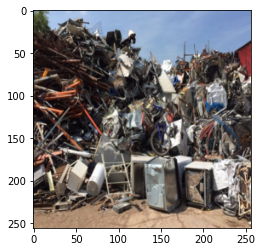

In [186]:
image_prediction('cans.jpg')

This is paper.


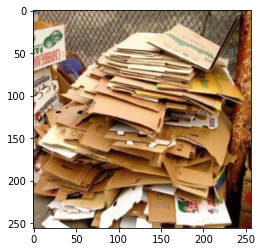

In [187]:
image_prediction('cardboard.jpg')

This is plastic.


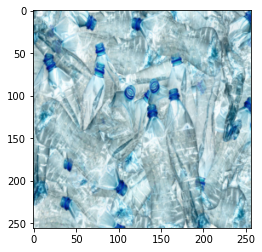

In [188]:
image_prediction('plastic.jpg')

This is metal.


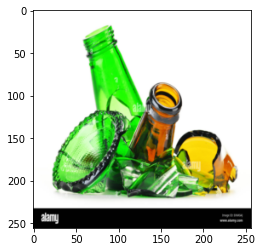

In [189]:
image_prediction('glass.jpg')

This is trash.


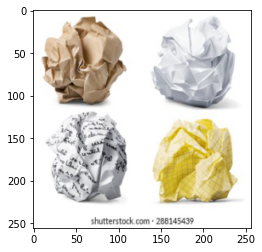

In [190]:
image_prediction('paper-trash.jpg')

This is paper.


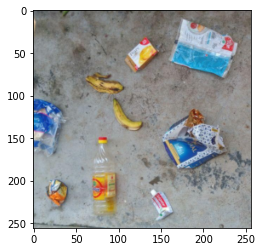

In [191]:
image_prediction('mixed-trash.jpg')